In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.utils import to_categorical

def carica_spettrogrammi(cartella_tsla, cartella_kk):
    """
    Carica gli spettrogrammi per TSLA e KK, etichettandoli correttamente.
    
    - cartella_tsla: percorso della cartella con gli spettrogrammi di TSLA.
    - cartella_kk: percorso della cartella con gli spettrogrammi di KK.
    """
    spettrogrammi = []
    labels = []
    
    # Carica spettrogrammi TSLA
    for file in os.listdir(cartella_tsla):
        if file.endswith('.png'):
            img = Image.open(os.path.join(cartella_tsla, file)).convert('RGB')
            img_resized = img.resize((128, 128))  # Ridimensiona tutte le immagini
            spettrogrammi.append(np.array(img_resized))
            labels.append(0)  # Etichetta TSLA come 0

    # Carica spettrogrammi KK
    for file in os.listdir(cartella_kk):
        if file.endswith('.png'):
            img = Image.open(os.path.join(cartella_kk, file)).convert('RGB')
            img_resized = img.resize((128, 128))  # Ridimensiona tutte le immagini
            spettrogrammi.append(np.array(img_resized))
            labels.append(1)  # Etichetta KK come 1

    # Converti a numpy array e normalizza
    spettrogrammi = np.array(spettrogrammi) / 255.0
    labels = np.array(labels)
    
    return spettrogrammi, labels

# Carica gli spettrogrammi
spettrogrammi, labels = carica_spettrogrammi('/Users/roberto/Desktop/UNI 3^ ANNO/tesi/TslaKK/outputtssslaaa', '/Users/roberto/Desktop/UNI 3^ ANNO/tesi/TslaKK/outpitkkk')

# Suddividi i dati in train (70%), validation (20%) e test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(spettrogrammi, labels, test_size=0.30, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, stratify=y_temp, random_state=42)

# Converti le etichette in formato categorico
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def crea_cnn():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))  # Due classi: TSLA, KK

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Creazione del modello CNN
model = crea_cnn()

# Mostra il riassunto del modello
model.summary()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,578 (28.20 MB)

 Trainable params: 7,392,578 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Correzione del percorso per il checkpoint del modello
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)


In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Definisci callback per l'early stopping e per salvare il miglior modello
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Addestramento del modello
history = model.fit(X_train, y_train_cat, 
                    validation_data=(X_val, y_val_cat),
                    epochs=50, 
                    batch_size=32, 
                    callbacks=[early_stop, checkpoint],
                    verbose=1)


Epoch 1/50
76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5058 - loss: 1.2570
Epoch 1: val_loss improved from inf to 0.68024, saving model to best_model.keras


OSError: [Errno 30] Read-only file system: 'best_model.keras'

In [6]:
# Definisci un percorso dove hai i permessi di scrittura, ad esempio una cartella sul desktop
checkpoint = ModelCheckpoint('/Users/roberto/Desktop/best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Addestramento del modello
history = model.fit(X_train, y_train_cat, 
                    validation_data=(X_val, y_val_cat),
                    epochs=50, 
                    batch_size=32, 
                    callbacks=[early_stop, checkpoint],
                    verbose=1)


Epoch 1/50
76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6478 - loss: 0.6468
Epoch 1: val_loss improved from inf to 0.43876, saving model to /Users/roberto/Desktop/best_model.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.6489 - loss: 0.6457 - val_accuracy: 0.8103 - val_loss: 0.4388
Epoch 2/50
76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8152 - loss: 0.4258
Epoch 2: val_loss improved from 0.43876 to 0.19262, saving model to /Users/roberto/Desktop/best_model.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.8160 - loss: 0.4242 - val_accuracy: 0.9372 - val_loss: 0.1926
Epoch 3/50
76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9317 - loss: 0.2017
Epoch 3: val_loss improved from 0.19262 to 0.11534, saving model to /Users/roberto/Desktop/best_model.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.9319 - loss: 0.2011 - val_accuracy: 0.9529 - val_loss: 0.1153
Epoch 4/50
76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9671 - loss

In [7]:
# Valutazione sul test set
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=1)
print(f'Accuracy sul test set: {test_acc * 100:.2f}%')


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9912 - loss: 0.0274
Accuracy sul test set: 98.84%


In [9]:
# Importa le librerie necessarie
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
              precision    recall  f1-score   support

        TSLA       0.98      1.00      0.99       173
          KK       1.00      0.98      0.99       173

    accuracy                           0.99       346
   macro avg       0.99      0.99      0.99       346
weighted avg       0.99      0.99      0.99       346



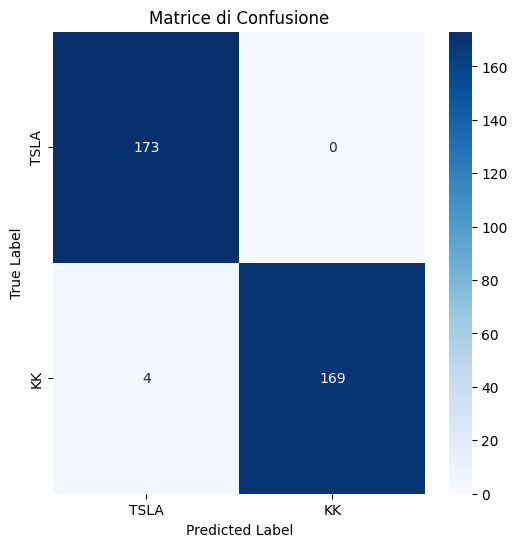

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Previsioni sul test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Converte le probabilità in etichette

# Mostra il classification report
print(classification_report(y_test, y_pred_classes, target_names=['TSLA', 'KK']))

# Matrice di confusione
cm = confusion_matrix(y_test, y_pred_classes)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['TSLA', 'KK'], yticklabels=['TSLA', 'KK'])
plt.title('Matrice di Confusione')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


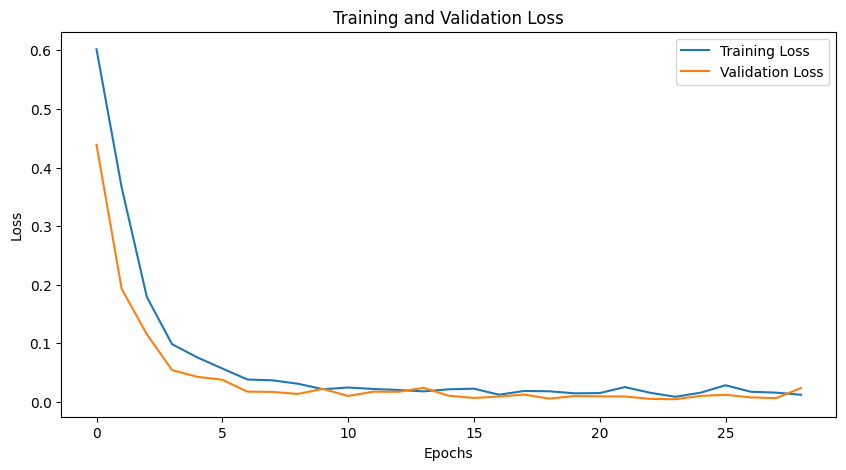

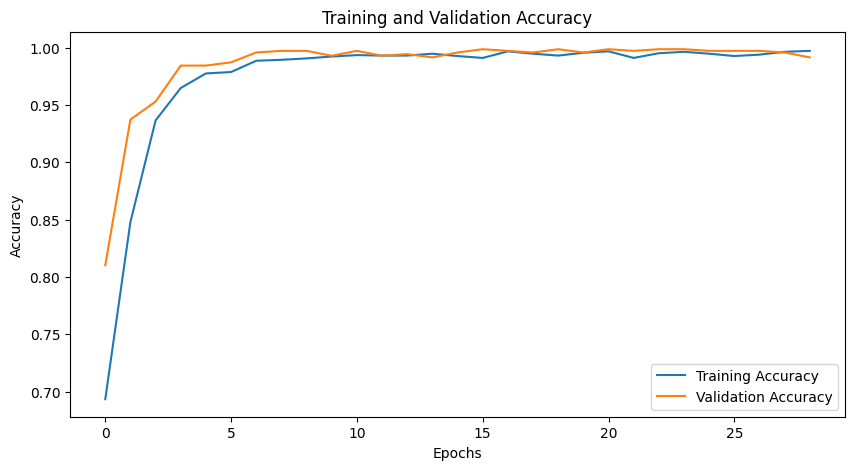

In [11]:
# Grafico per Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Grafico per Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [12]:
# Salva il modello finale in un formato leggibile da Keras
model.save('/Users/roberto/Desktop/UNI 3^ ANNO/tesi/spectrogrammi/output/final_model.keras')


Se in futuro vuoi caricare il modello salvato per fare delle previsioni, puoi usare il seguente codice:

In [ ]:
from tensorflow.keras.models import load_model

# Carica il modello
model_caricato = load_model('/Users/roberto/Desktop/UNI 3^ ANNO/tesi/spectrogrammi/output/final_model.keras')

# Previsioni su nuovi dati
y_new_pred = model_caricato.predict(X_test)
